Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# Introduction to anomaly detection

This notebook provides a short primer on detecting contextual anomalies in time series data. 

After completing this notebook, you will have developed an intuitive understanding of a common algorithmic approach to anomaly detection that we are going to be relying on throughout this course.

We will try to achieve this goal using the following steps:
1. Create a hypothetical time series dataset
2. Apply simple, but common anomaly detection algorithm
3. Understand the limitations of this approach in dealing with
    - seasonal trends (e.g. higher energy consumption on the weekends than on weekdays)
    - linear trends (e.g. growth over time)
4. Improve the anomaly detection algorithm to be robust against seasonal and linear trends

> **Important:** We created these notebooks such that you can run them as a Jupyter, or as a databricks notebook.  We ask you to keep this in mind because this has several implications:
- In several cells of code you will find a hint about enabling or disabling lines of codes, depending whether you are running thess notebooks on Jupyter or on Databricks.

We begin by importing all necessary Python modules, and by setting some global configuration settings.

In [1]:
#%matplotlib inline 
import os

#  Let's start with loading python modules we need for this course
from rstl import STL
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn
import numpy as np
import urllib

# you can change this to adjust the size of figures to work well with your screen resolution
wide_figure = (16,4)

## Create a hypothetical time series dataset

We begin by creating a timeseries of hypothetical telemetry data.  We will use this timeseries throughout this notebook. The advantage of using your own timeseries is that because we know its properties, we can make precise predictions about the outcome of our analyses. 

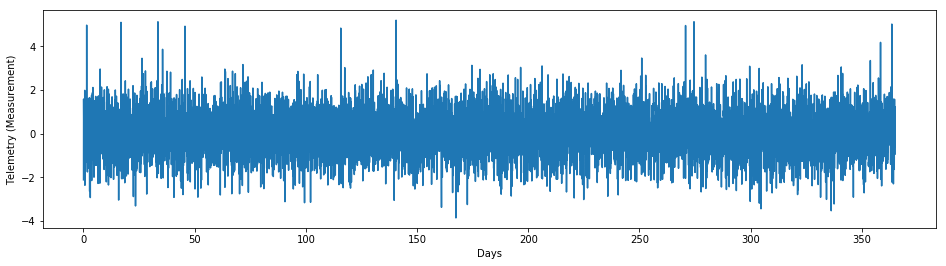

In [2]:
n_measures = 24 * 365 # we simulate one measurement per hour for one year

# define nature of anomalies
p_anom = 0.001 # probability of anomalies
loc, scale = 5, .1 # we sample anomalies from a normal distribution with mean 'loc' and std 'scale'

x = np.linspace(1, n_measures, n_measures)
x_tics = x / 24 # we plot x-axis in days

# let's create a time series normal data, by drawing independent samples from a normal distribution
y_reg = np.random.normal(size=int(round(n_measures * (1 - p_anom)))).tolist()

# anomalies are also drawn from a normal distribution, but with a different mean and standard deviation
y_anom = np.random.normal(loc=loc, scale=scale, size=int(round(n_measures * (p_anom)))).tolist()

# we concatentate the two lists into an array, and shuffle the array
y = np.array(y_reg + y_anom)
np.random.shuffle(y)

# let's see what this looks like
plt.close()
fig = plt.figure(figsize=wide_figure)
plt.plot(x_tics,y)
plt.xlabel("Days")
plt.ylabel("Telemetry (Measurement)")
display()

# Basic approaches to anomaly detection

Let's start with one of the simplest approaches to anomaly detection:
1. We calculate the mean and the standard deviation of all instances (measurements)
2. We mark every instance that is too far from the mean as an anomaly

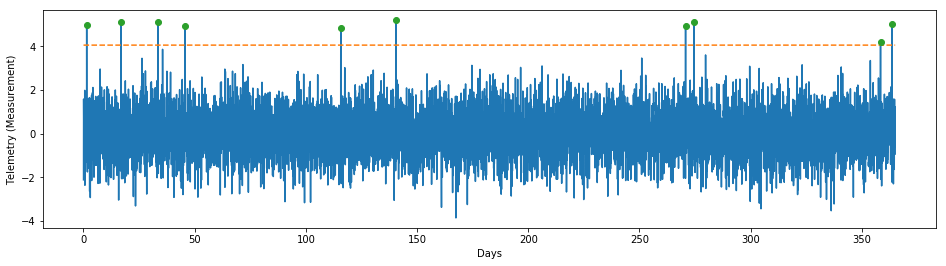

In [3]:
tolerance = 4 # how many standard deviations does an instance have to be from the mean in order to be an anomaly

m = np.mean(y)
std = np.std(y)
cutoff = m + tolerance * std

# find the array indices of extreme values (anomalies)
idx = np.where(y > cutoff)[0].tolist()

# create an array that is all NaN, except for the anomalies
anoms = np.full(y.shape[0], np.nan)
anoms[idx] = y[idx] # copy the value of the anomaly
anoms_orig = np.array(anoms) # let's store a copy of the anomalies for later

plt.close()
fig = plt.figure(figsize=wide_figure)
plt.plot(x_tics, y)
plt.plot(x_tics, [cutoff] * len(x_tics), '--')
plt.plot(x_tics, anoms, 'o')
plt.xlabel("Days")
plt.ylabel("Telemetry (Measurement)")
display()

### Hands-on lab

Can you write a function that does what we did above: accept a time series as input, detects the anomalies, and returns the anomalies and the cutoff.  The function should also accept a `keyword argument` to specify the above `tolerance` of the anomaly detection.  

This exercise will ensure you understand how we defined anomalies and offer you a chance to practice your Python skills.

In [4]:
import numpy as np

def detect_anomalies(<arguments>):

    # your code goes here
    
    return anoms, cutoff

SyntaxError: invalid syntax (<ipython-input-4-421e67a14371>, line 3)

In [7]:
# uncomment the below lines to see the solution
filename = 'detect_anomalies.py'
urllib.request.urlretrieve(
    os.path.join('https://raw.githubusercontent.com/Azure/LearnAI-ADPM/master/solutions/', filename),
    filename=filename)
with open(filename) as f:
    print(f.read())

HTTPError: HTTP Error 404: Not Found

Now test your code. Are the results the same as before?

In [6]:
anoms, cutoff = detect_anomalies(y)

plt.close()
fig = plt.figure(figsize=wide_figure)
plt.plot(x_tics, y)
plt.plot(x_tics, anoms, 'o')
plt.plot(x_tics, [cutoff] * len(x_tics), '--')
plt.plot(x_tics, anoms, 'o')
plt.xlabel("Days")
plt.ylabel("Telemetry (Measurement)")
display()

NameError: name 'detect_anomalies' is not defined

### End of Lab

## Limitations of this approach

Looks like this worked really well, but what if you use some more realistic data. Real-world data often has seasonal or linear trends.  Cars tend to consume more oil per mile when they get older.  Power consumption is typically higher on weekdays than on weekends, when office buildings are empty.

### Seasonal trends

Let's see how this approach performs if the data have some seasonality: weekly cycles.

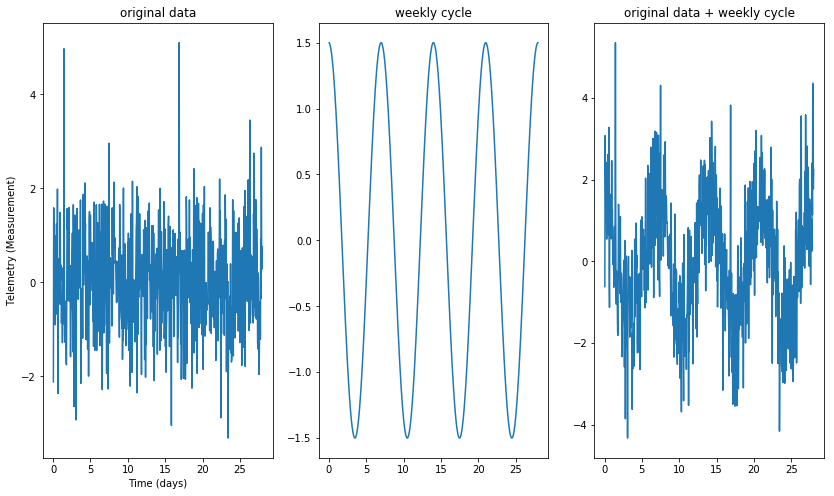

In [8]:
sample_size = 24 * 7 * 4 # for display purposes

# seasonal trend (weekly)
amp = 1.5 # amplitude of the weekly effect
mod = amp * np.cos(2 * np.pi * x / 24 / 7)
y_mod = y + mod # create a new timeseries by adding the seasonal effect to the original data

plt.close()
fig, ax = plt.subplots(1,3, figsize=(14,8))
ax[0].plot(x_tics[:sample_size], y[:sample_size])
ax[1].plot(x_tics[:sample_size], mod[:sample_size])
ax[2].plot(x_tics[:sample_size], y_mod[:sample_size])
ax[0].set_xlabel('Time (days)')
ax[0].set_ylabel("Telemetry (Measurement)")
ax[1].set_title('weekly cycle')
ax[2].set_title('original data + weekly cycle')
ax[0].set_title('original data')
display()

Let's use the same approach as before and see how it performs on this new time series.

In [9]:
anoms, cutoff = detect_anomalies(y_mod)

plt.close()
fig, ax = plt.subplots(1,2, figsize=(12,8))

ax[0].plot(x_tics, y_mod)
ax[0].plot(x_tics, anoms, 'o')
ax[0].plot(x_tics, [cutoff] * len(x_tics), '--')
ax[0].set_xlabel("Days")
ax[0].set_ylabel("Telemetry (Measurement)")
ax[0].set_title("original data + weekly cycle")

ax[1].plot(x_tics, y)
ax[1].plot(x_tics, anoms_orig, 'o')
ax[1].set_xlabel('Time (days)')
ax[1].set_title("original")
display()

NameError: name 'detect_anomalies' is not defined

It looks like our approach was still able to recover some of the anomalies, but this would clearly not be acceptable.  Imagine you have a situation where not detecting an anomaly could lead to massive costs due to equipment damage!

### Linear trends

Let's add a linear trend to our data to see how the algorithm performs.

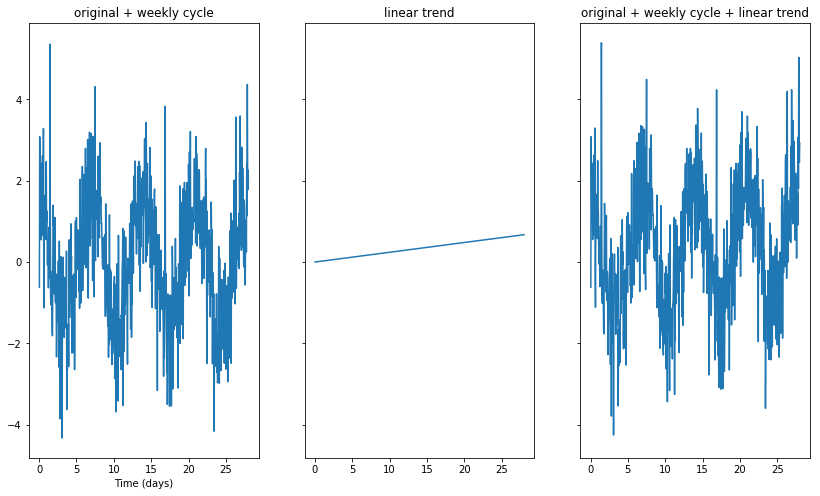

In [10]:
slope = .001 # slope of the linear trend
linear_trend = x * slope
y_mod_lin = y_mod + linear_trend

plt.close()
fig, ax = plt.subplots(1,3, figsize=(14,8), sharey=True)
ax[0].plot(x_tics[:sample_size], y_mod[:sample_size])
ax[1].plot(x_tics[:sample_size], linear_trend[:sample_size])
ax[2].plot(x_tics[:sample_size], y_mod_lin[:sample_size])
ax[0].set_xlabel('Time (days)')
ax[0].set_title('original + weekly cycle')
ax[1].set_title('linear trend')
ax[2].set_title('original + weekly cycle + linear trend')
display()

Run the algorithm and see how it does. If you don't see any anomalies, try lowering the `tolerance`.

In [11]:
tolerance = 4

anoms, cutoff = detect_anomalies(y_mod_lin, tolerance=tolerance)

plt.close()
fig, ax = plt.subplots(1,2, figsize=(12,8))

ax[0].plot(x_tics, y_mod_lin)
ax[0].plot(x_tics, anoms, 'o')
ax[0].plot(x_tics, [cutoff] * len(x_tics), '--')
ax[0].set_xlabel('Time (days)')
ax[0].set_title('orig + weekly cycle + linear trend')

ax[1].plot(x_tics, y)
ax[1].plot(x_tics, anoms_orig, 'o')
ax[1].set_xlabel('Time (days)')
ax[1].set_title("original")
display()

NameError: name 'detect_anomalies' is not defined

What do you think? Did it work? You could try lowering the `tolerance` (e.g. 2). Did that help?

It looks like if we have seasonal and linear trends in our time series, the simple approach from above doesn't work at all!

Let's see whether we can fix that.

## Improve the anomaly detection algorithm to be robust against seasonal and linear trends

One common approach to this dilema is STL, a versatile and robust method for decomposing time series. STL is an acronym for "Seasonal and Trend decomposition using Loess". 

The STL method was developed by Cleveland, Cleveland, McRae, & Terpenning (1990).

STL has several strengths:
- It handles *any type* of seasonality, including monthly, weekly, daily seasonality.
- The seasonal component is allowed to change over time, and the rate of change can be controlled by the user.
- The smoothness of the trend-cycle can also be controlled by the user.
- It can be robust to outliers (i.e., the user can specify a robust decomposition), so that occasional unusual observations will not affect the estimates of the trend-cycle and seasonal components.

Let's give it a try.

The STL decomposition method accepts a time series as input, and decomposes the time series into a linear trend, seasonal trend, and a remainder.  Put another way, the remainder is what is left if we subtract the linear and seasonal trends from the original time series.

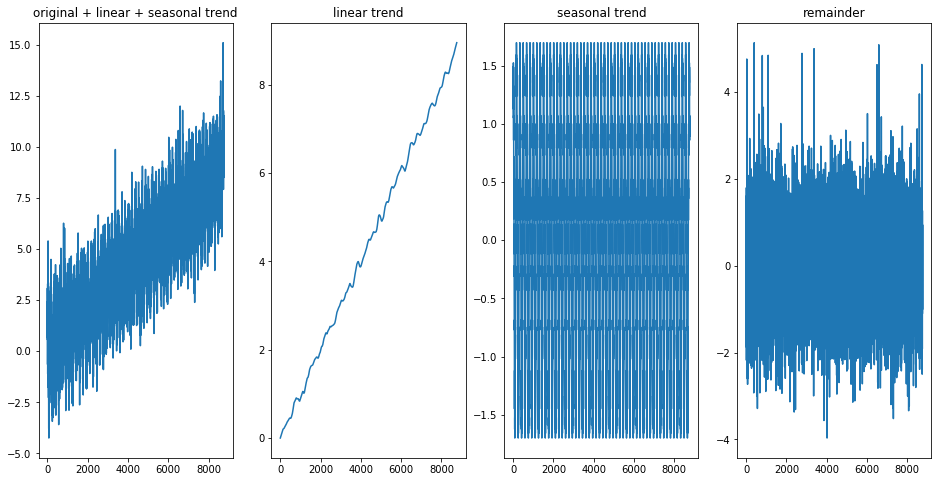

In [12]:
stl = STL(y_mod_lin, freq=24*7, s_window='periodic')

plt.close()
fig, ax = plt.subplots(1,4, figsize=(16,8))
ax[0].plot(x, y_mod_lin) # the time series
ax[0].set_title("original + linear + seasonal trend")
ax[1].plot(x, stl.trend) # linear trend
ax[1].set_title("linear trend")
ax[2].plot(x, stl.seasonal) # sesonal trend
ax[2].set_title("seasonal trend")
ax[3].plot(x, stl.remainder) # remainder
ax[3].set_title("remainder")
display()

In [25]:
stl.tren

0

Now let's try whether we can apply our approach to anomaly detection. 

If STL did its job, the `remainder` should look just like the original time series, before we added linear and seasonal trends. So if we run our original approach to anomaly detection, we should be able to detect the same anomalies on the remainder after running STL decomposition as we did on the original data.

In [ ]:
anoms, cutoff = detect_anomalies(stl.remainder)

plt.close()
fig, ax = plt.subplots(1,2, figsize=(12,8))
ax[0].plot(x_tics, stl.remainder)
ax[0].plot(x_tics, anoms, 'o')
ax[0].plot(x_tics, [cutoff] * len(x_tics), '--')
ax[0].set_xlabel('Time (days)')
ax[0].set_title("stl.remainder")

ax[1].plot(x_tics, y)
ax[1].plot(x_tics, anoms_orig, 'o')
ax[1].set_xlabel('Time (days)')
ax[1].set_title("original data")
display()

It looks like we were able to recover all the anomalies!

## Conclusion

By now you should have an intuitive understanding of the approach to anomaly detection we will follow in this lab. 

We will follow a divide and conquer strategy, of first removing linear and seasonal trends, so that we can simply mark all extreme values as anomalies.

In the process of this notebook you were also introduced to the following:
- How to generate a dataset for exploring your idea.  Using an idealized dataset can be very helpful, because you know exactly what the result should look like.  For example, in our case we knew that we were successful if could discover the same anomalies as the ones that we had discovered orignally.
- A simple, but common approach to detecting point anomalies.
- The STL algorithm, a very powerful tool that can be used even outside of anomaly detection, as part of data preparation or preprocessing.

### Hands-on lab

Can you update your function for anomaly detection from above to perform STL first, before applying anomaly detection?

In [ ]:
import numpy as np
from rstl import STL

def detect_anomalies_stl(ts, tolerance=4):
    
    ## your code goes here
    
    return anoms, stl.remainder

In [ ]:
# # uncomment the below lines to see the solution
# filename = 'detect_anomalies_stl.py'
# urllib.request.urlretrieve(
#     os.path.join('https://raw.githubusercontent.com/Azure/LearnAI-ADPM/master/solutions/', filename),
#     filename=filename)
# with open(filename) as f:
#     print(f.read())

Let's see whether the results are as expected.  If things went well, you should see to figures that almost look identical.

In [ ]:
anoms, stl_remainder = detect_anomalies_stl(y_mod_lin, tolerance=4)

plt.close()
fig, ax = plt.subplots(1,2, figsize=(12,8))
ax[0].plot(x_tics, stl_remainder)
ax[0].plot(x_tics, anoms, 'o')
ax[0].set_xlabel('Time (days)')
ax[0].set_title("stl.remainder")

ax[1].plot(x_tics, y)
ax[1].plot(x_tics, anoms_orig, 'o')
ax[1].set_xlabel('Time (days)')
ax[1].set_title("original data")
display()

### End of lab

## The end

Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.